## **Financial Time-Series Anomaly Detection**

### **Importing Libraries**

In [2]:
import yfinance as yf # For accessing Yahoo Finance Stock market dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Loading dataset**

In [3]:
# Defining the stock symbol and time period
stock_symbol = "GOOGL"  # We can change it to any stock (e.g., "AAPL", "MSFT")
start_date = "2020-01-01"
end_date = "2024-01-01"

# Downloading stock data
df = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head(5)

Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2020-01-02,68.186813,68.186813,67.081324,67.176978,27278000
2020-01-03,67.830116,68.439411,67.122682,67.156563,23408000
2020-01-06,69.638054,69.663459,67.306008,67.337388,46768000
2020-01-07,69.503548,69.921535,69.326691,69.770083,34330000
2020-01-08,69.998253,70.337523,69.379995,69.489097,35314000


In [5]:
print(df.shape)

(1006, 5)


### **Calculating Financial Indicators**

In [6]:
# Ensuring single-level column names
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# Simple Moving Average (SMA)
df["SMA_20"] = df["Close"].rolling(window=20).mean()

# Exponential Moving Average (EMA)
df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()

# Relative Strength Index (RSI)
def compute_RSI(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df["RSI_14"] = compute_RSI(df["Close"])

# Bollinger Bands
rolling_std = df["Close"].rolling(window=20).std()
df["BB_Middle"] = df["SMA_20"]
df["BB_Upper"] = df["SMA_20"] + (2 * rolling_std)
df["BB_Lower"] = df["SMA_20"] - (2 * rolling_std)

In [7]:
# Filling missing values instead of dropping all rows
df.fillna(method="bfill", inplace=True)  # Backward Fill
df.fillna(method="ffill", inplace=True)  # Forward Fill (as a backup)

# Displaying first few rows
print(df.head())

Price           Close       High        Low       Open    Volume     SMA_20  \
Date                                                                          
2020-01-02  68.186813  68.186813  67.081324  67.176978  27278000  71.557027   
2020-01-03  67.830116  68.439411  67.122682  67.156563  23408000  71.557027   
2020-01-06  69.638054  69.663459  67.306008  67.337388  46768000  71.557027   
2020-01-07  69.503548  69.921535  69.326691  69.770083  34330000  71.557027   
2020-01-08  69.998253  70.337523  69.379995  69.489097  35314000  71.557027   

Price          EMA_20     RSI_14  BB_Middle   BB_Upper   BB_Lower  
Date                                                               
2020-01-02  68.186813  87.450547  71.557027  75.195098  67.918955  
2020-01-03  68.152842  87.450547  71.557027  75.195098  67.918955  
2020-01-06  68.294291  87.450547  71.557027  75.195098  67.918955  
2020-01-07  68.409458  87.450547  71.557027  75.195098  67.918955  
2020-01-08  68.560772  87.450547  71.5

<ipython-input-7-300c5c20f7c9>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)  # Backward Fill
<ipython-input-7-300c5c20f7c9>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)  # Forward Fill (as a backup)


### **Anomaly detection using isolation forest**

In [8]:
from sklearn.ensemble import IsolationForest

# Preparing features for anomaly detection
features = ["Close", "SMA_20", "EMA_20", "RSI_14", "BB_Middle", "BB_Upper", "BB_Lower"]
df_features = df[features]

# Training Isolation Forest model
iso_forest = IsolationForest(contamination=0.02, random_state=42)
df["Anomaly"] = iso_forest.fit_predict(df_features)
# Mark anomalies
df["Anomaly"] = df["Anomaly"].map({1: 0, -1: 1})  # Converting to 0 (normal) and 1 (anomaly)

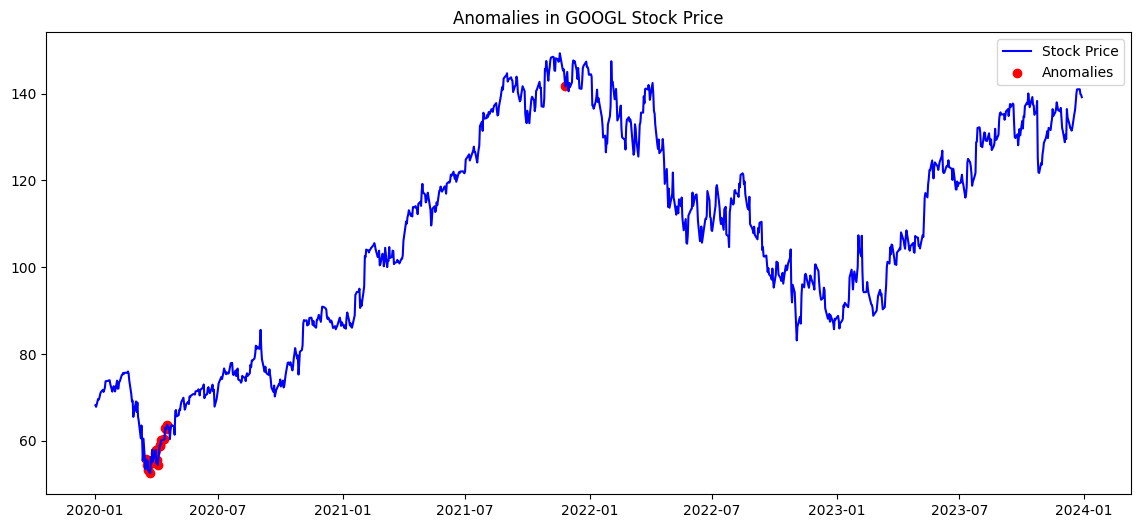

In [9]:
# Plotting anomalies
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["Close"], label="Stock Price", color="blue")
plt.scatter(df[df["Anomaly"] == 1].index, df[df["Anomaly"] == 1]["Close"], color="red", label="Anomalies", marker="o")
plt.legend()
plt.title(f"Anomalies in {stock_symbol} Stock Price")
plt.show()

### **Time-Series forecasting with LSTM**

### Importing Libraries

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


### Preparing data

In [12]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[["Close"]])

# Creating sequences for LSTM
def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 50
X, y = create_sequences(df_scaled, seq_length)


### Data splitting into training and testing

In [13]:
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

### Building LSTM model

In [18]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")


### Model Training

In [25]:
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018 - val_loss: 9.6298e-04
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - val_loss: 7.1997e-04
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 7.8495e-04
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 7.2649e-04
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 8.6393e-04
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 9.1877e-04
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 6.9980e-04
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - val_loss: 6.6514e-04
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 9.3422e-04
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 12/200
24/

### Making Predictions and plotting them

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


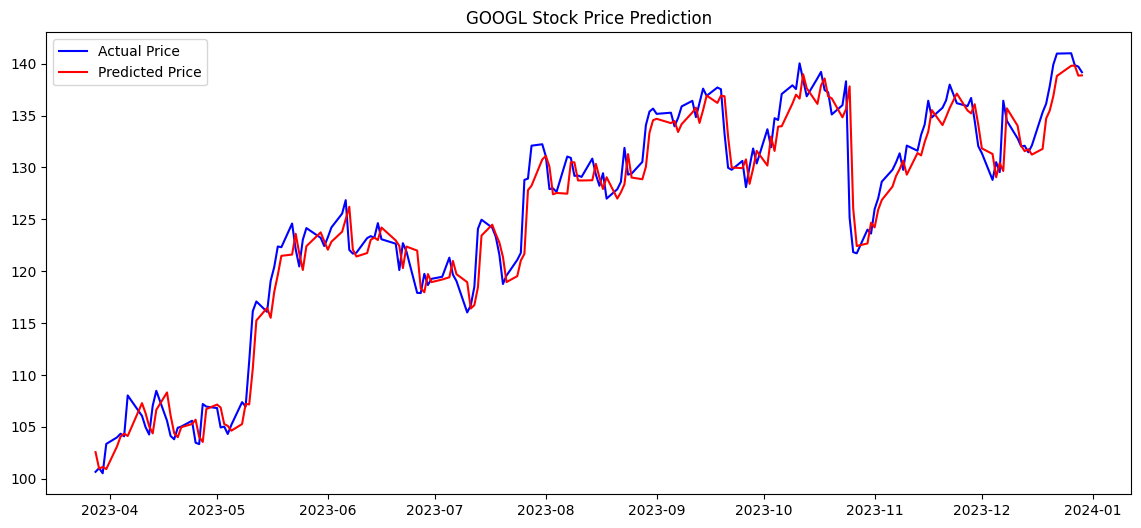

In [26]:
# Making predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plotting actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual Price", color="blue")
plt.plot(df.index[-len(y_test):], predictions, label="Predicted Price", color="red")
plt.legend()
plt.title(f"{stock_symbol} Stock Price Prediction")
plt.show()

### Following are the results of the the above trained model by changing number of epochs for enhacing model performance.

### Epochs = 40
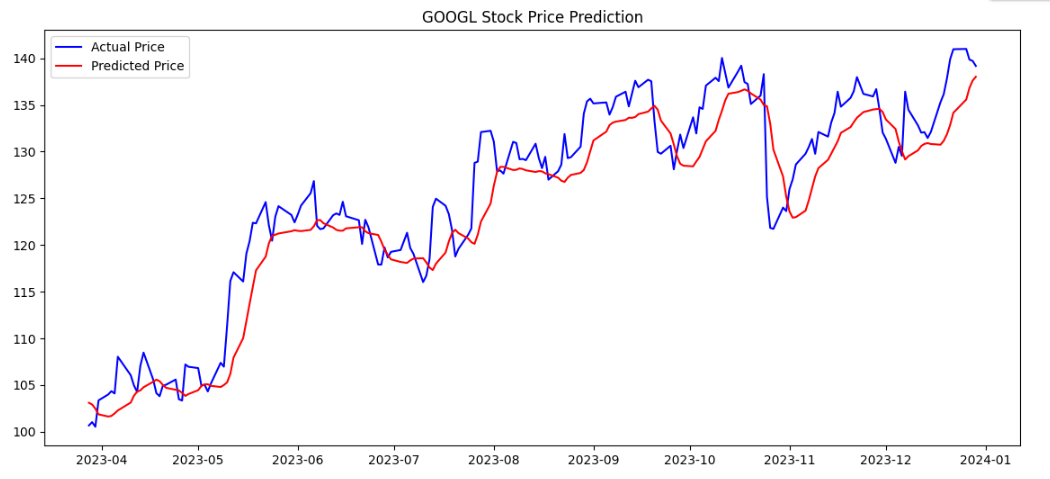

### Epochs = 80
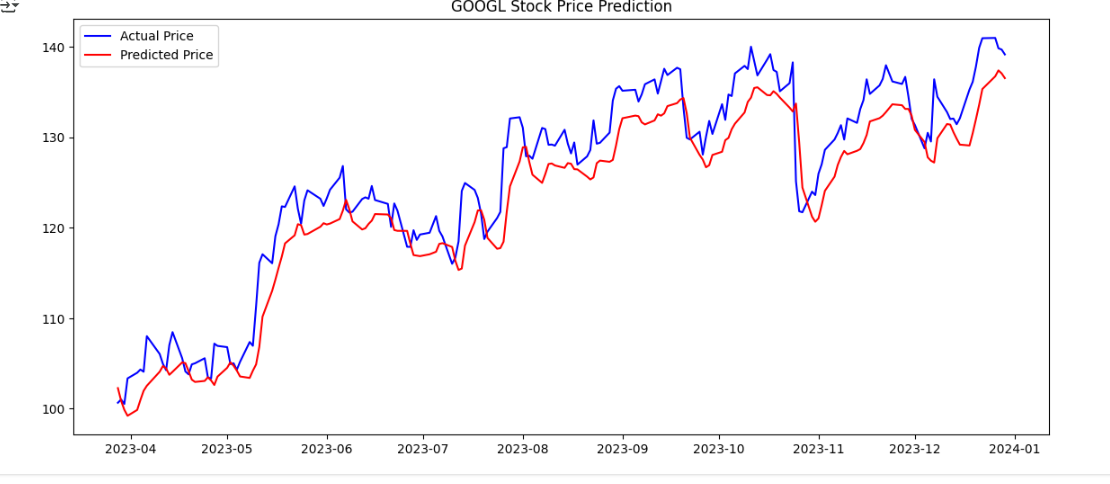

### Epochs = 200
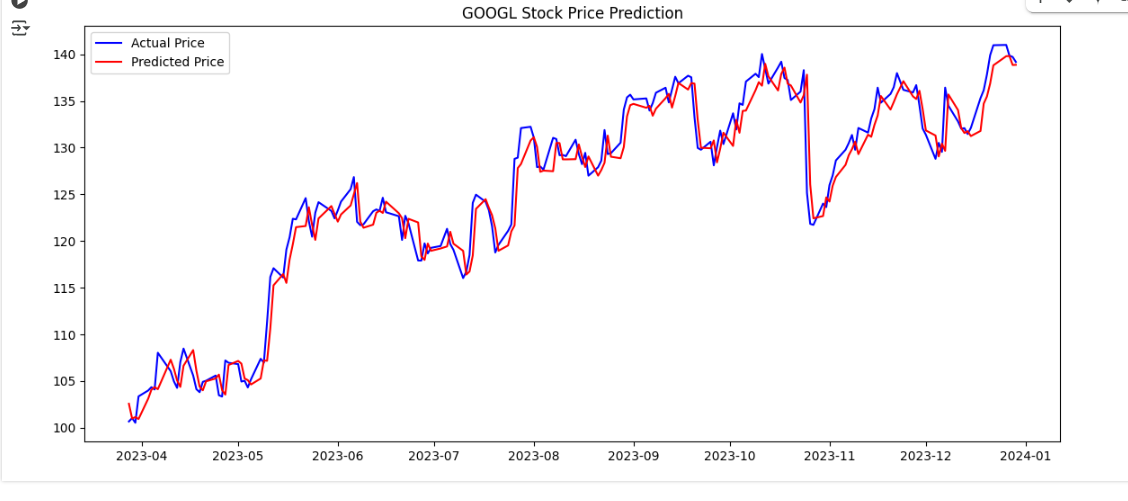

### As we see in the above figures that, increasing the number of epochs, the difference between the actual and predicted values decreases and hence our model performance increses.

### **Detecting Deviations in forecasted prices**

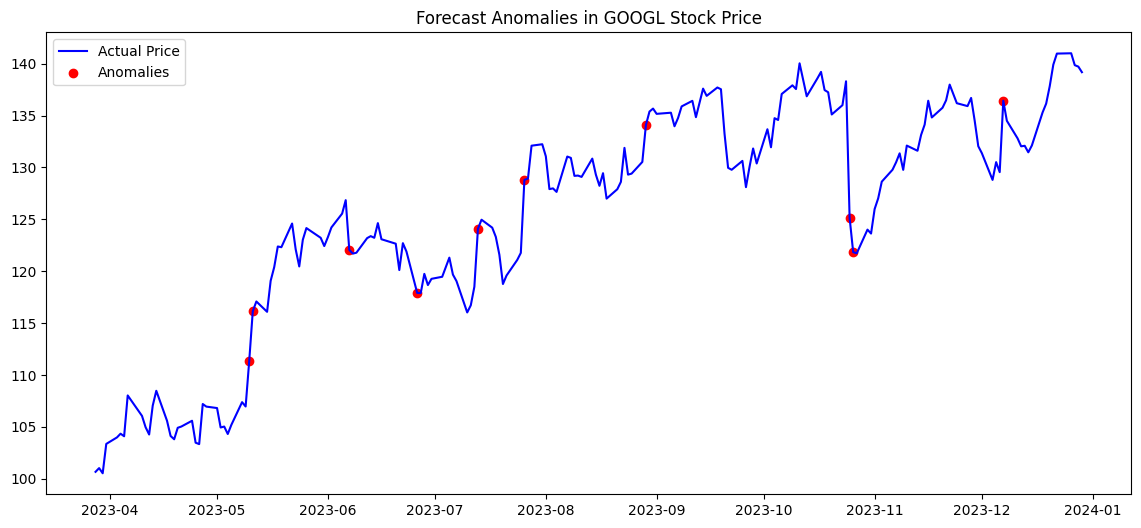

In [27]:
df_results = df.iloc[-len(y_test):].copy()
df_results["Predicted_Close"] = predictions

# Calculating residuals
df_results["Deviation"] = np.abs(df_results["Close"] - df_results["Predicted_Close"])
threshold = df_results["Deviation"].quantile(0.95)

# Flag anomalies
df_results["Forecast_Anomaly"] = df_results["Deviation"] > threshold

# Plotting detected anomalies
plt.figure(figsize=(14, 6))
plt.plot(df_results.index, df_results["Close"], label="Actual Price", color="blue")
plt.scatter(df_results[df_results["Forecast_Anomaly"]].index, df_results[df_results["Forecast_Anomaly"]]["Close"], color="red", label="Anomalies", marker="o")
plt.legend()
plt.title(f"Forecast Anomalies in {stock_symbol} Stock Price")
plt.show()

### **Summarizing Report**

### Based on the anomaly detection in the above stock price predictions, here are some possible market manipulations that could explain unusual price movements:

### **Pump and Dump:** Sudden spikes in price followed by a sharp drop could indicate a pump-and-dump scheme, where traders artificially inflate a stock's price with false hype before selling off for profit.

### **Spoofing:** Large buy or sell orders are placed to create a false impression of demand/supply, then canceled before execution. This can cause short-term price anomalies.

### **Insider Trading:** Unusual price jumps before major company announcements could indicate insider trading, where people with privileged information act on it before the news is public

### **Wash Trading:** If a stock shows erratic but controlled fluctuations, traders might be executing fake trades between themselves to manipulate volume and attract other investors.

### **Algorithmic Manipulations:** Unusual price jumps before major company announcements could indicate insider trading, where people with privileged information act on it before the news is public

### **News-Based Manipulations:** A sudden spike or drop in price around misleading news reports could indicate manipulation via false media narratives.